# Closure Phase Example

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import numpy as np
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from utils.vis_utils import n_imgs_total, true_image_size

Welcome to eht-imaging! v 1.2.4 



## IGM Training

Train IGM to solve inverse problem of reconstructing images of the black hole M87* from noisy realistic visibility amplitudes and closure phases. The resulting model will be saved to `results_batched/[folder_name]/model_checkpoints`, where `[folder_name]` is generated by the parameters.

In [3]:
# Task parameters
task = "closure-phase"
dataset = "m87"
latent_dim = 40

# Closure phase hyperparameters
alpha = 0.001
beta = 1e5

In [ ]:
# Run script to IGM and save model to
!python igm_multi_inv_learning_new.py --task {task} --latent_dim {latent_dim} --generator_type "deepdecoder" --num_imgs {n_imgs_total} --dataset {dataset} --image_size {true_image_size} --batchGD --GMM_EPS 1e-3 --latent_type gmm --num_epochs 200000 --gamma {alpha} --cphase_count "min" --centroid {beta} 10000

## Visualize results

Show reconstructions from example trained IGM. More ways to visualize results can be found in the scripts in the `visualizations/` directory.

In [4]:
from generative_model import model_utils
from utils.vis_utils import latest_epoch_path

def reconstruction_from_model(model_path, n_samples=40):
    generator_chkpt = latest_epoch_path(model_path, pattern='cotrain-generator_*.pt')
    generator, G = model_utils.get_generator(latent_dim, true_image_size, 'deepdecoder')
    generator.load_state_dict(torch.load(generator_chkpt, map_location=device))
    generator.eval()

    recon_means = []
    for img_ex in range(n_imgs_total):
        latent_chkpt = os.path.join(model_path, f'gmm-{img_ex}.npz')
        with np.load(latent_chkpt) as data:
            mu = torch.tensor(data['mu']).to(device)
            L = torch.tensor(data['L']).to(device)

        spread_cov = (L @ (L.t())).to(device) + torch.diag(torch.ones(latent_dim)).to(device) * (1e-3)
        prior = torch.distributions.MultivariateNormal(mu, spread_cov)
        z_sample = prior.sample((n_samples,)).to(device)
        img_samples = G(z_sample)
        image = img_samples.detach().cpu().numpy()
        image = image.mean(axis=0)
        recon_means.append(image)
    return recon_means

In [5]:
# Load example trained IGM from model_checkpoints subdirectory
model_path = 'example_model_checkpoints'
reconstructions = reconstruction_from_model(model_path)

using epoch cotrain-generator_0190000.pt


In [6]:
import ehtplot.color
import matplotlib.pyplot as plt
from utils.figure_utils import time_angle

def black_hole_plot(img):
    plt.figure()
    plt.imshow(img.squeeze(), cmap='afmhot_10us', vmin=0, vmax=1)
    plt.axis('off')
    plt.show()

def time_angle_plot(img_list):
    img_list = [img.squeeze() for img in img_list]
    time_angle_arr = time_angle(img_list, verbose=True).transpose()
    black_hole_plot(time_angle_arr)

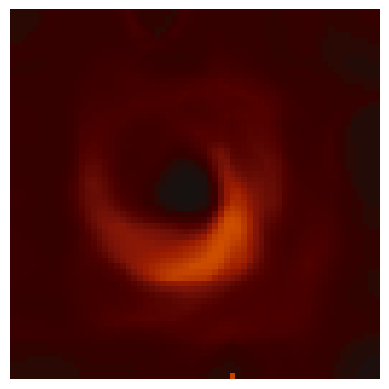

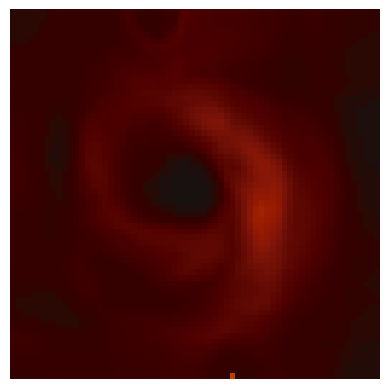

In [7]:
# Display reconstructions
frame_idxs = [0, 20]
for idx in frame_idxs:
    black_hole_plot(reconstructions[idx])

frame 0
frame 10
frame 20
frame 30
frame 40
frame 50


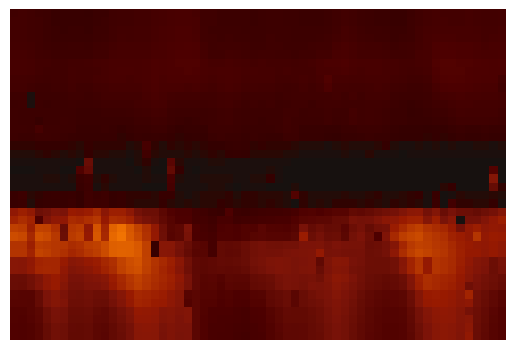

In [9]:
# Time-angle plot
time_angle_plot(reconstructions)

## Baselines

Run scripts to generate baseline reconstructions: MEM-RML, TV-RML, TSV-RML, Deep Image Prior, and AmbientGAN. Reconstructions for each frame will be saved to the `baseline_results/m87/[baseline_name]` directory.

In [ ]:
# RML baselines
!python baselines/rml_baselines.py --dataset {dataset}

In [ ]:
# Deep Image Prior
!python baselines/dip.py --task {task} --dataset {dataset}

In [ ]:
# AmbientGAN
!python baselines/ambient_gan_exps.py --task {task} --dataset {dataset}